# COGS 185: Advanced Machine Learning Methods
### Enhancing Sentiment Classification: A Comparative Study of SVMs, RNNs (LSTM), and Transformers (BERT) Using Twitter Entity Dataset

# Names

- Aditya Tomar
- Shay Samat

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import re
from nltk.tokenize  import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, roc_curve, precision_score, recall_score, f1_score, roc_auc_score, auc
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers.core import Flatten
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy , CategoricalCrossentropy

from tensorflow.keras.utils import to_categorical

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup,TFBertForSequenceClassification

from tqdm import tqdm, trange,tnrange,tqdm_notebook
import random
import os
import io


2023-06-16 09:48:02.897986: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Cleaning

In [ ]:
df = pd.read_csv('Twitter_Data.csv')
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [ ]:
df['category'].mask(df['category'] == -1,'negative',  inplace=True)
df['category'].mask(df['category'] == 0,'normal',  inplace=True)
df['category'].mask(df['category'] == 1,'positive',  inplace=True)
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,negative
1,talk all the nonsense and continue all the dra...,normal
2,what did just say vote for modi welcome bjp t...,positive
3,asking his supporters prefix chowkidar their n...,positive
4,answer who among these the most powerful world...,positive


In [ ]:
df.category.unique()

array(['negative', 'normal', 'positive', nan], dtype=object)

In [ ]:
df.isna().sum()

clean_text    4
category      7
dtype: int64

In [ ]:
df= df.dropna()

In [ ]:
df.isna().sum()

clean_text    0
category      0
dtype: int64

In [ ]:
df['category'].value_counts()

positive    72249
normal      55211
negative    35509
Name: category, dtype: int64

In [ ]:
dist = df['category'].value_counts()
import plotly.graph_objects as go
def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()
ditribution_plot(x= dist.index, y= dist.values, name= 'Class Distribution train')

In [ ]:
def clean_text(df, field):
    df[field] = df[field].str.replace(r"@"," at ")
    df[field] = df[field].str.replace("#[^a-zA-Z0-9_]+"," ")
    df[field] = df[field].str.replace(r"[^a-zA-Z(),\"'\n_]"," ")
    df[field] = df[field].str.replace(r"http\S+","")
    df[field] = df[field].str.lower()
    return df

clean_text(df,'clean_text')

,clean_text,category
0,when modi promised minimum government maximum...,negative
1,talk all the nonsense and continue all the dra...,normal
2,what did just say vote for modi welcome bjp t...,positive
3,asking his supporters prefix chowkidar their n...,positive
4,answer who among these the most powerful world...,positive
...,...,...
162975,why these crores paid neerav modi not reco...,negative
162976,dear rss terrorist payal gawar what about modi...,negative
162977,did you cover her interaction forum where she ...,normal
162978,there big project came into india modi dream p...,normal


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
df['clean_text'] = tokenizer.texts_to_sequences(df['clean_text'])
df['clean_text']

0         [42, 1, 303, 721, 66, 1683, 806, 1113, 40, 234...
1         [286, 16, 2, 1104, 3, 711, 16, 2, 790, 8, 37, ...
2         [24, 53, 41, 99, 37, 4, 1, 997, 21, 505, 5, 50...
3         [380, 19, 498, 4652, 105, 43, 1213, 1, 53, 125...
4         [388, 22, 809, 80, 2, 170, 921, 123, 135, 116,...
                                ...                        
162975    [32, 80, 464, 570, 2401, 1, 6, 2682, 17, 25, 2...
162976    [306, 360, 529, 12770, 9874, 24, 36, 1, 1191, ...
162977        [53, 5, 1679, 232, 2555, 7348, 117, 186, 396]
162978    [62, 180, 554, 356, 191, 7, 1, 913, 554, 15, 6...
162979    [14, 5, 256, 681, 36, 26, 32843, 117, 4804, 11...
Name: clean_text, Length: 162969, dtype: object

In [ ]:
df['category'].mask(df['category'] == 'negative',-1,  inplace=True)
df['category'].mask(df['category'] == 'normal',0,  inplace=True)
df['category'].mask(df['category'] == 'positive',1,  inplace=True)
df['category']

0         -1
1          0
2          1
3          1
4          1
          ..
162975    -1
162976    -1
162977     0
162978     0
162979     1
Name: category, Length: 162969, dtype: object

# EDA

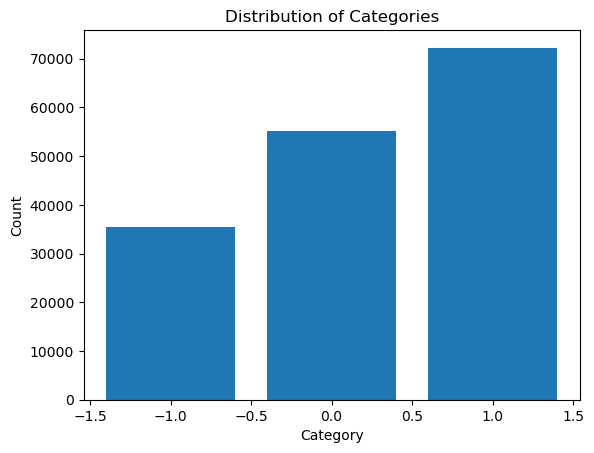

In [ ]:
# Check the distribution of categories
category_counts = df['category'].value_counts()
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Categories')
plt.show()

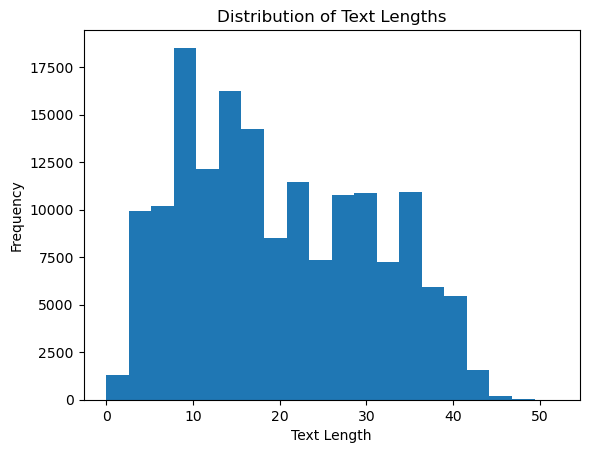

In [ ]:

# Analyze text data
text_lengths = df['clean_text'].apply(lambda x: len(x))
plt.hist(text_lengths, bins=20)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

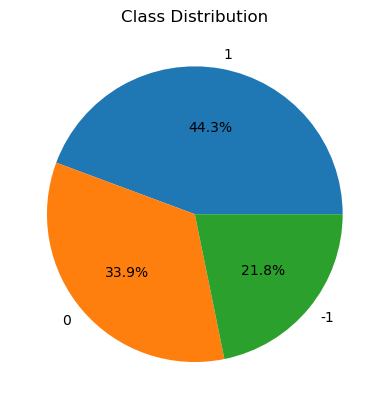

In [ ]:
# Handle class imbalance
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

# LSTM

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'],df['category'], test_size=0.2, random_state=40)

In [ ]:
print('X_train:',len(X_train))
print('y_train:',len(y_train))
print('X_test:',len(X_test))
print('y_test:',len(y_test))

X_train: 130375
y_train: 130375
X_test: 32594
y_test: 32594


In [ ]:
X_train = pad_sequences( X_train, maxlen=100 ,dtype='float32')
X_test = pad_sequences( X_test, maxlen=100 ,dtype='float32')

In [ ]:
len(tokenizer.index_word)

100651

In [ ]:
model_1 = Sequential()
model_1.add(Embedding(len(tokenizer.index_word)+1, input_length= 100 ,output_dim =50))
model_1.add(Bidirectional(LSTM(100)))
model_1.add(Flatten())
model_1.add(Dense(250, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile("adam", loss= 'binary_crossentropy' ,metrics=["accuracy"])
model_1.summary()

2023-06-16 09:48:19.193406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 09:48:19.196725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 09:48:19.199351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           5032600   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              120800    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 250)               50250     
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 251       
                                                        

In [ ]:
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)

y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [ ]:
history_1 = model_1.fit(X_train , y_train ,batch_size=64, epochs=7,
                    validation_data=(X_test , y_test))

Epoch 1/7


2023-06-16 09:48:19.969489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 09:48:19.970613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 09:48:19.972774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2038/2038 [==============================] - ETA: 0s - loss: -70.7611 - accuracy: 0.4924

2023-06-16 09:52:32.071813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 09:52:32.072993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 09:52:32.074410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2038/2038 [==============================] - 265s 128ms/step - loss: -70.7611 - accuracy: 0.4924 - val_loss: -660.3456 - val_accuracy: 0.6985
Epoch 2/7
2038/2038 [==============================] - 259s 127ms/step - loss: -4519.2910 - accuracy: 0.6134 - val_loss: -9604.0537 - val_accuracy: 0.6722
Epoch 3/7
2038/2038 [==============================] - 251s 123ms/step - loss: -17057.4043 - accuracy: 0.6214 - val_loss: -24442.9883 - val_accuracy: 0.6820
Epoch 4/7
2038/2038 [==============================] - 268s 132ms/step - loss: -36175.3164 - accuracy: 0.6273 - val_loss: -13822.4092 - val_accuracy: 0.5196
Epoch 5/7
2038/2038 [==============================] - 299s 147ms/step - loss: -71658.0547 - accuracy: 0.6113 - val_loss: -101316.6016 - val_accuracy: 0.6749
Epoch 6/7
2038/2038 [==============================] - 296s 145ms/step - loss: -162984.2188 - accuracy: 0.6154 - val_loss: -191181.9375 - val_accuracy: 0.6621
Epoch 7/7
2038/2038 [==============================] - 281s 138ms/step -

In [ ]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [ ]:
model = Sequential()
model.add(Embedding(len(tokenizer.index_word)+1, input_length= 100 ,output_dim =100))
model.add(LSTM(100))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

model.compile("adam", loss= 'categorical_crossentropy' ,metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          10065200  
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 128)               12928     
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 10,158,915
Trainable params: 10,158,915
Non-trainable params: 0
_________________________________________________________________


2023-06-16 10:20:19.376301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 10:20:19.377902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 10:20:19.379506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
history = model.fit(X_train , y_train ,batch_size=256, epochs=4,
                    validation_data=(X_test , y_test))

Epoch 1/4


2023-06-16 10:20:19.848630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 10:20:19.850384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 10:20:19.852223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

510/510 [==============================] - ETA: 0s - loss: 0.4165 - accuracy: 0.8329

2023-06-16 10:23:18.874366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 10:23:18.875603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 10:23:18.877083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

510/510 [==============================] - 187s 363ms/step - loss: 0.4165 - accuracy: 0.8329 - val_loss: 0.1951 - val_accuracy: 0.9373
Epoch 2/4
510/510 [==============================] - 153s 300ms/step - loss: 0.1164 - accuracy: 0.9652 - val_loss: 0.1536 - val_accuracy: 0.9529
Epoch 3/4
510/510 [==============================] - 154s 301ms/step - loss: 0.0785 - accuracy: 0.9773 - val_loss: 0.1565 - val_accuracy: 0.9543
Epoch 4/4
510/510 [==============================] - 166s 326ms/step - loss: 0.0561 - accuracy: 0.9830 - val_loss: 0.1768 - val_accuracy: 0.9527


In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert true labels from one-hot encoded vectors to categorical labels
true_labels = np.argmax(y_test, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, y_pred_labels)
precision = precision_score(true_labels, y_pred_labels, average='weighted')
recall = recall_score(true_labels, y_pred_labels, average='weighted')
f1 = f1_score(true_labels, y_pred_labels, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC Score:", roc_auc)

2023-06-16 10:31:20.590757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 10:31:20.592319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 10:31:20.593957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1019/1019 [==============================] - 13s 12ms/step
Accuracy: 0.9527213597594649
Precision: 0.9530315464533189
Recall: 0.9527213597594649
F1 Score: 0.9523341602867318
ROC-AUC Score: 0.9923309577934606


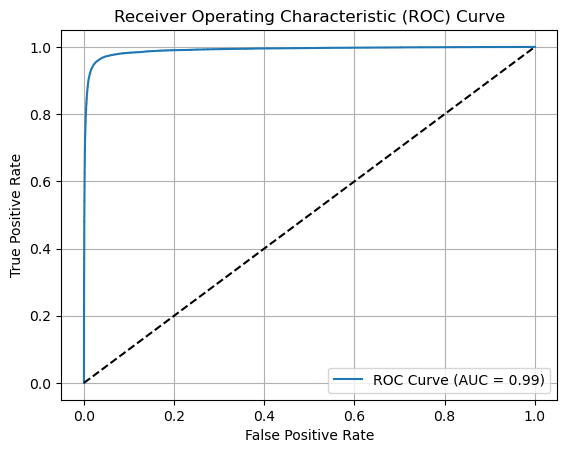

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred.ravel())

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random classifier curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
results = model.evaluate(X_test, y_test, batch_size=100)

326/326 [==============================] - 10s 32ms/step - loss: 0.1768 - accuracy: 0.9527


# BERT

In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

# Preprocess the dataset
df["category"] = df["category"].astype(int)  # Convert sentiment labels to integers

# Adjust the label range to start from 0
df["category"] = df["category"].apply(lambda x: x + 1)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

# Preprocess the text data
train_texts = train_data["clean_text"].apply(str).tolist()
test_texts = test_data["clean_text"].apply(str).tolist()

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the text and convert it to input features
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_data["category"].values
)).shuffle(len(train_data)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_data["category"].values
)).batch(32)

# Load the pre-trained BERT model
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Define the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

# Train the model
model.fit(train_dataset, epochs=3, validation_data=test_dataset)

# Evaluate the model on the test set
model.evaluate(test_dataset)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


2023-06-15 16:42:22.292490: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4075/4075 [==============================] - 47994s 12s/step - loss: 0.5294 - accuracy: 0.7914 - val_loss: 0.3180 - val_accuracy: 0.9024
Epoch 2/3
1580/4075 [==========>...................] - ETA: 7:55:46 - loss: 0.2728 - accuracy: 0.9153

# SVM

In [ ]:
# Preprocess the dataset
df["category"] = df["category"].apply(lambda x: x + 1)  # Adjust label range to start from 1

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Preprocess the text data
train_texts = train_data["clean_text"].apply(str).tolist()
test_texts = test_data["clean_text"].apply(str).tolist()

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_texts)
test_vectors = vectorizer.transform(test_texts)

# Prepare the labels
train_labels = train_data["category"].values
test_labels = test_data["category"].values

#parameter grid
param_grid = {
    'C': [1, 5, 7, 10],
    'loss': ['hinge', 'squared_hinge'],
    'max_iter': [2000, 5000],
}
# Create the SVM model
model = LinearSVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(train_vectors, train_labels)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'C': 5, 'loss': 'hinge', 'max_iter': 5000}
Best score:  0.9503892617449665


In [ ]:
# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(test_vectors)

# Compute evaluation metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred, average='weighted')
recall = recall_score(test_labels, y_pred, average='weighted')
f1 = f1_score(test_labels, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9563416579738602
Precision: 0.9562500111548994
Recall: 0.9563416579738602
F1 Score: 0.95625676494118


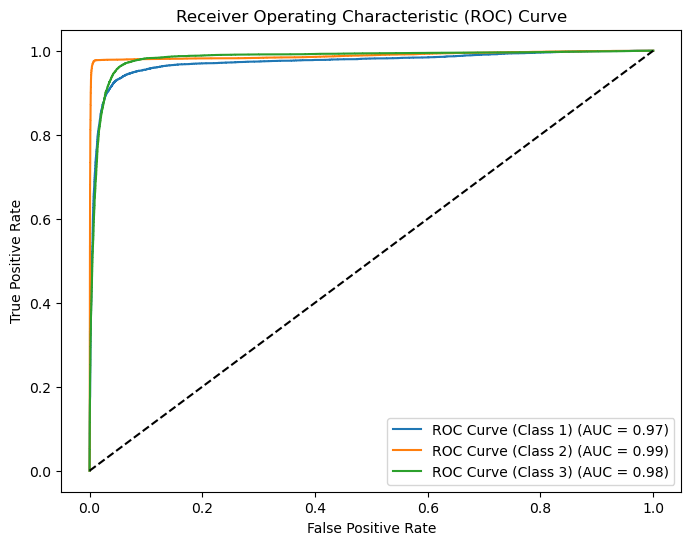

In [ ]:
# Convert labels to one-hot encoded vectors
test_labels_binary = label_binarize(test_labels, classes=[1, 2, 3])  # Replace [1, 2, 3] with your actual class labels

# Predict probabilities on the test set using the best model
probabilities = best_model.decision_function(test_vectors)

# Compute the ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(test_labels_binary[0])):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binary[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(test_labels_binary[0])):
    plt.plot(fpr[i], tpr[i], label='ROC Curve (Class {}) (AUC = {:.2f})'.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Split the dataset into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Preprocess the text data
train_texts = train_data["clean_text"].apply(str).tolist()
test_texts = test_data["clean_text"].apply(str).tolist()

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_texts)
test_vectors = vectorizer.transform(test_texts)

# Prepare the labels
train_labels = train_data["category"].values
test_labels = test_data["category"].values

# Create the SVM model
model = LinearSVC()

# Train the model
model.fit(train_vectors, train_labels)

LinearSVC()

In [ ]:
predictions = model.predict(test_vectors)

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='weighted')
recall = recall_score(test_labels, predictions, average='weighted')
f1 = f1_score(test_labels, predictions, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9468920660244217
Precision: 0.9465892020982758
Recall: 0.9468920660244217
F1 Score: 0.946629696759769


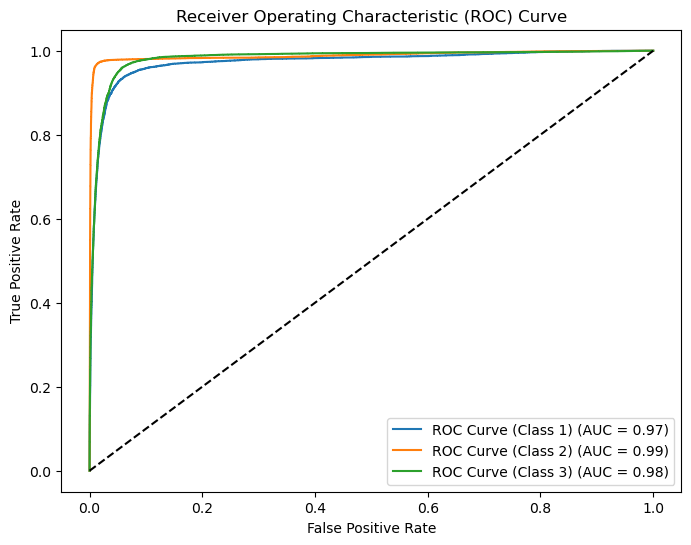

In [ ]:
# Convert labels to one-hot encoded vectors
test_labels_binary = label_binarize(test_labels, classes=[1, 2, 3])  # Replace [1, 2, 3] with your actual class labels

# Predict probabilities on the test set using the best model
probabilities = model.decision_function(test_vectors)

# Compute the ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(test_labels_binary[0])):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binary[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(test_labels_binary[0])):
    plt.plot(fpr[i], tpr[i], label='ROC Curve (Class {}) (AUC = {:.2f})'.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
